In [11]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [122]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [14]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [36]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
get_stn_output_v2 = K.function([model.layers[0].input], [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [16]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [17]:
def stn_transform(stn_func, x, batch_size=512):
    
    out = np.zeros_like(x)
    n_step = np.ceil(len(x) / float(batch_size)).astype(np.int32)
    for step in range(n_step):
        start = step * batch_size
        end = (step + 1) * batch_size
        out[start:end] = stn_func([x[start:end], 0])[0]*0.5 + 0.5
    return out

In [18]:
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=1)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=1)
y_val_bal = y_val_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

---
# 1

In [11]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-3, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

In [12]:
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2848
STEP: 50 	Loss: 0.0811
STEP: 100 	Loss: 0.0681
STEP: 150 	Loss: 0.0570
STEP: 200 	Loss: 0.0471
STEP: 250 	Loss: 0.0430
STEP: 300 	Loss: 0.0407
STEP: 350 	Loss: 0.0355
STEP: 400 	Loss: 0.0302
STEP: 450 	Loss: 0.0260
STEP: 500 	Loss: 0.0271
Train Acc|Loss:	0.9998|0.0002
Val Acc|Loss:	0.9993|0.0007
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0223
STEP: 50 	Loss: 0.0232
STEP: 100 	Loss: 0.0204
STEP: 150 	Loss: 0.0187
STEP: 200 	Loss: 0.0170
STEP: 250 	Loss: 0.0165
STEP: 300 	Loss: 0.0146
STEP: 350 	Loss: 0.0122
STEP: 400 	Loss: 0.0121
STEP: 450 	Loss: 0.0104
STEP: 500 	Loss: 0.0088
Train Acc|Loss:	1.0000|0.0000
Val Acc|Loss:	0.9993|0.0007
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0096
STEP: 50 	Loss: 0.0093
STEP: 100 	Loss: 0.0089
STEP: 150 	Loss: 0.0078
STEP: 200 	Loss: 0.0066
STEP: 250 	Loss: 0.0070
STEP: 300 	Loss: 0.0063
STEP: 350 	Loss: 0.0063
STEP: 400 	Loss: 0.0053
STEP: 450 	Loss: 0.0045
STEP: 500 	Los

In [13]:
featnet.eval_model(sess, (X_train_stn, y_train_stn))

(1.0, 0.0)

In [14]:
featnet.eval_model(sess, (X_val_stn, y_val_stn))

(0.9993197278911564, 0.0006802721088435374)

In [15]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9666666666666667


[0.] [1.] [2.5513928e-27] [2.940074e-36]
[0.02779884]


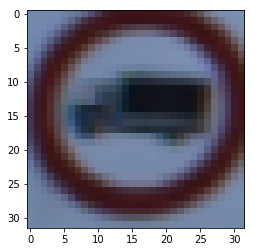

[0.] [1.] [3.1644036e-33] [3.3142637e-28]
[0.02779884]


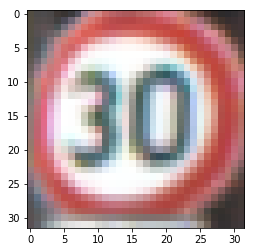

[0.] [1.] [8.334831e-34] [1.4652672e-31]
[0.02779884]


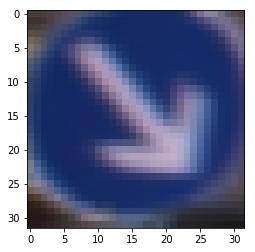

[0.] [1.] [3.148407e-37] [1.2362884e-35]
[0.02779884]


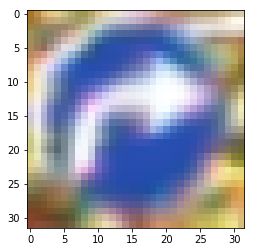

[0.] [1.] [2.5943347e-09] [1.5105742e-17]
[0.02779884]


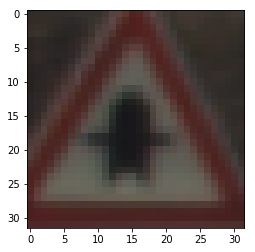

[0.] [1.] [1.4359327e-26] [6.162462e-25]
[0.02779884]


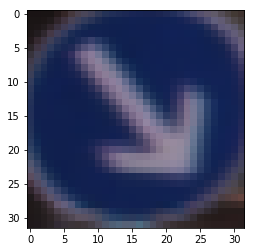

[0.] [1.] [4.2753734e-26] [0.]
[0.02779884]


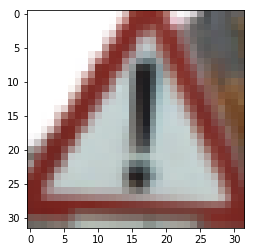

[0.] [1.] [4.1452765e-13] [1.0620435e-17]
[0.02779884]


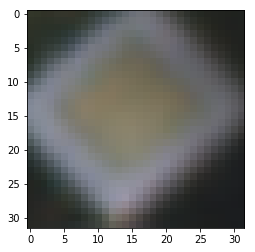

[0.] [1.] [9.766915e-35] [0.]
[0.02779884]


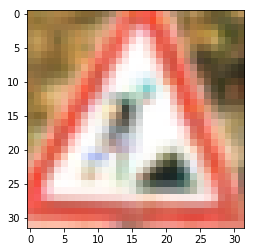

[0.] [1.] [2.3951624e-23] [1.2329151e-22]
[0.02779884]


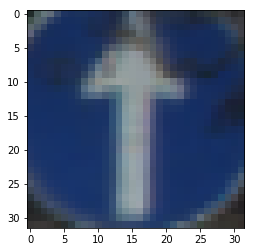

In [16]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.] [2.9858758e-05] [1.] [0.9999999]
[0.9798095]


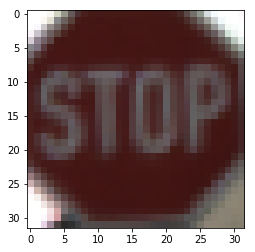

[0.] [3.168833e-09] [1.] [1.]
[0.9798109]


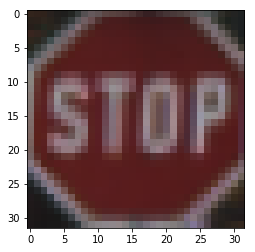

[0.] [6.6954167e-06] [0.9999999] [0.9998247]
[0.97980255]


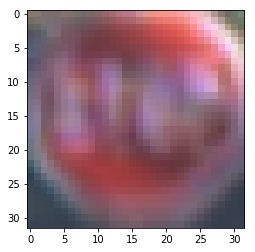

[0.] [3.2682128e-13] [1.] [1.]
[0.9798109]


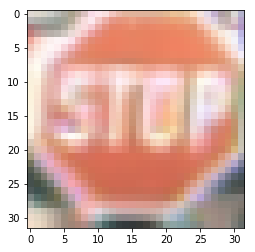

[0.] [2.3055331e-07] [1.] [1.]
[0.9798109]


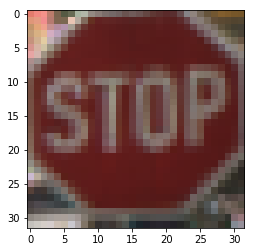

[0.] [4.1914078e-07] [1.] [1.]
[0.9798108]


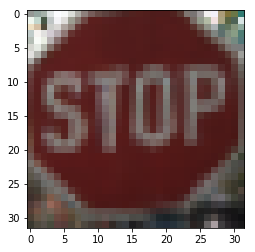

[0.] [6.0532705e-07] [1.] [1.]
[0.9798108]


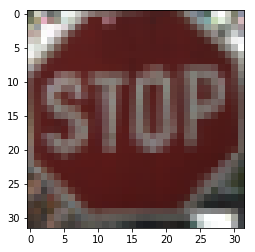

[0.] [3.253897e-07] [1.] [1.]
[0.9798109]


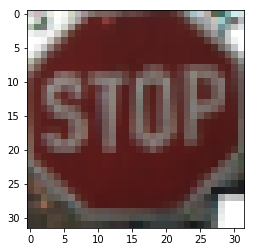

[0.] [8.6866254e-07] [1.] [1.]
[0.9798108]


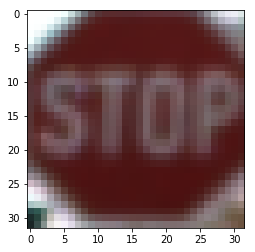

[0.] [1.8514738e-05] [1.] [0.9999994]
[0.97981]


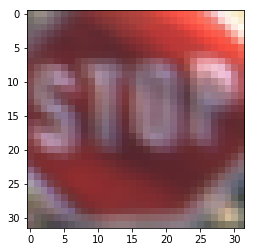

In [17]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

In [20]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="featnet")

[<tf.Variable 'featnet/conv2d_14/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_14/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_15/kernel:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_15/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_16/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_16/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_4/kernel:0' shape=(3520, 128) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_4/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_5/kernel:0' shape=(128, 32) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_5/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_6/kernel:0' shape=(32, 1) dtype=float32_ref>,
 <tf.Variable 'featnet/dense_6/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'featnet/conv2d_17/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 <t

In [25]:
var = [v for v in tf.trainable_variables() if "featnet_1/final_layer/dense_28/" in v.name]
sess.run(var)

[array([[ 1.9298517],
        [-2.27757  ],
        [ 2.85937  ],
        [ 2.2998435]], dtype=float32), array([-1.2769985], dtype=float32)]

---
# 2

In [28]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-3, save_path="model/featnet_v2.ckpt",
                  stn_weight=stn_weight)

In [29]:
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2593
STEP: 50 	Loss: 0.2380
STEP: 100 	Loss: 0.2300
STEP: 150 	Loss: 0.2105
STEP: 200 	Loss: 0.2032
STEP: 250 	Loss: 0.1884
STEP: 300 	Loss: 0.1760
STEP: 350 	Loss: 0.1654
STEP: 400 	Loss: 0.1651
STEP: 450 	Loss: 0.1497
STEP: 500 	Loss: 0.1421
Train Acc|Loss:	0.9798|0.0202
Val Acc|Loss:	0.9637|0.0363
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.1416
STEP: 50 	Loss: 0.1290
STEP: 100 	Loss: 0.1183
STEP: 150 	Loss: 0.1154
STEP: 200 	Loss: 0.1104
STEP: 250 	Loss: 0.1048
STEP: 300 	Loss: 0.1030
STEP: 350 	Loss: 0.0942
STEP: 400 	Loss: 0.0879
STEP: 450 	Loss: 0.0841
STEP: 500 	Loss: 0.0795
Train Acc|Loss:	0.9990|0.0010
Val Acc|Loss:	0.9977|0.0023
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0754
STEP: 50 	Loss: 0.0764
STEP: 100 	Loss: 0.0705
STEP: 150 	Loss: 0.0674
STEP: 200 	Loss: 0.0670
STEP: 250 	Loss: 0.0639
STEP: 300 	Loss: 0.0613
STEP: 350 	Loss: 0.0562
STEP: 400 	Loss: 0.0525
STEP: 450 	Loss: 0.0547
STEP: 500 	Los

In [30]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9888888888888889


[0.06707981] [0.] [0.14784892] [0.]
[0.0680783]


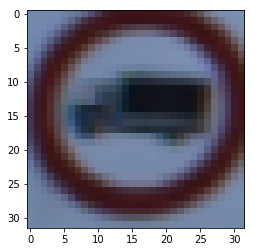

[0.00156881] [0.] [0.00712673] [0.]
[0.0680783]


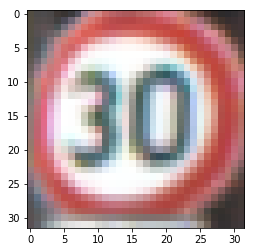

[0.12435373] [0.] [0.03310929] [0.]
[0.0680783]


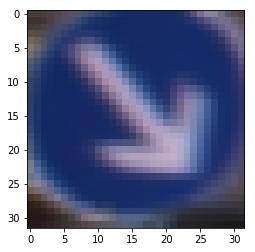

[0.00893375] [0.] [0.00341022] [0.]
[0.0680783]


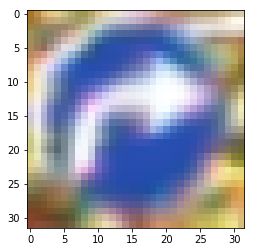

[0.11885143] [1.6888236e-16] [0.1409854] [1.5787735e-18]
[0.0680783]


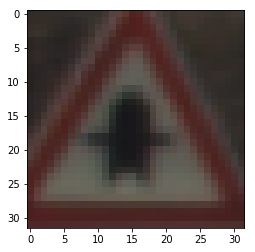

[0.17052336] [0.] [0.06793516] [0.]
[0.0680783]


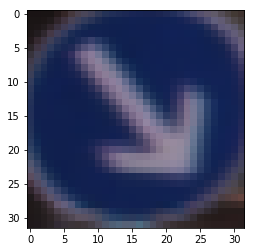

[0.00456791] [0.] [0.03056614] [0.]
[0.0680783]


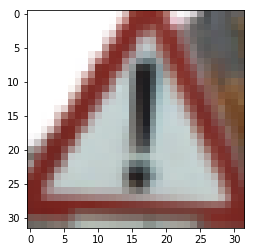

[0.02009718] [0.] [0.03910076] [4.1794796e-31]
[0.0680783]


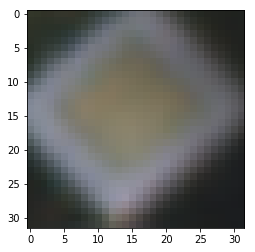

[0.00487472] [0.] [0.00159415] [0.]
[0.0680783]


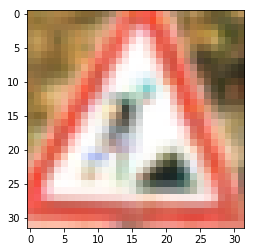

[0.12157124] [0.] [0.02829712] [0.]
[0.0680783]


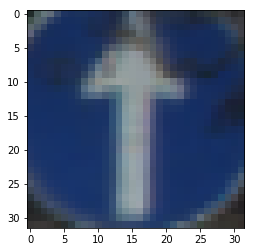

In [31]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.08645595] [1.] [0.12648052] [1.]
[0.94394237]


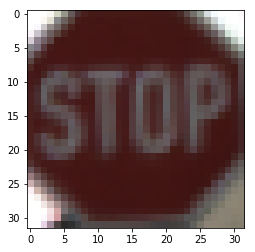

[0.03674234] [1.] [0.07006855] [1.]
[0.94394237]


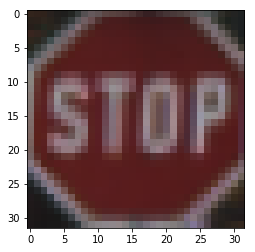

[0.01628668] [1.] [0.02892717] [0.99776316]
[0.94361264]


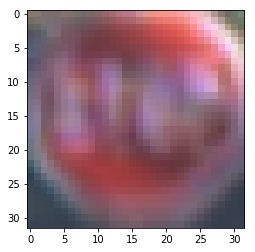

[0.00225788] [1.] [0.00404092] [1.]
[0.94394237]


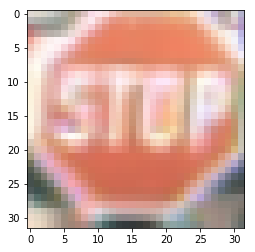

[0.04428295] [1.] [0.08314742] [1.]
[0.94394237]


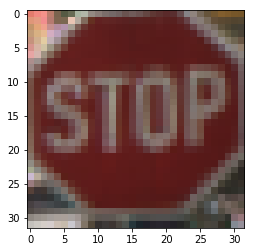

[0.04870374] [1.] [0.09414435] [1.]
[0.94394237]


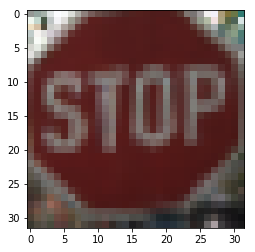

[0.0450777] [1.] [0.08869936] [1.]
[0.94394237]


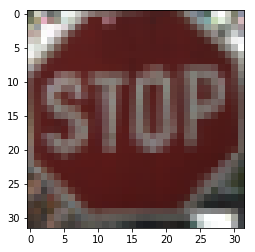

[0.04644004] [1.] [0.08967185] [1.]
[0.94394237]


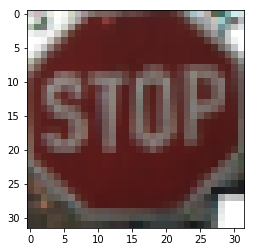

[0.05637848] [1.] [0.09961894] [1.]
[0.94394237]


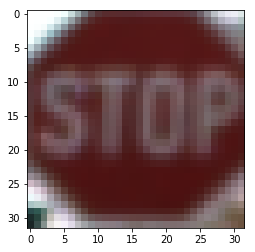

[0.0247838] [1.] [0.0400207] [1.]
[0.94394237]


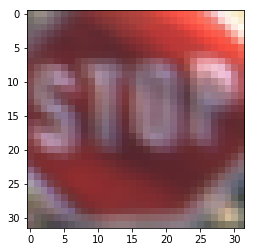

In [32]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

In [34]:
var = [v for v in tf.trainable_variables() if "featnet_3/final_layer/" in v.name]
sess.run(var)

[array([[-0.       ],
        [ 2.663234 ],
        [-0.       ],
        [ 2.7770398]], dtype=float32), array([-2.6165903], dtype=float32)]

### Observations

- The network does not use all four features in the decision process

---

# 5

In [14]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.2501
STEP: 50 	Loss: 0.1068
STEP: 100 	Loss: 0.0301
STEP: 150 	Loss: 0.0194
STEP: 200 	Loss: 0.0172
STEP: 250 	Loss: 0.0091
STEP: 300 	Loss: 0.0058
STEP: 350 	Loss: 0.0098
STEP: 400 	Loss: 0.0029
STEP: 450 	Loss: 0.0052
STEP: 500 	Loss: 0.0031
Train Acc|Loss:	0.9989|0.0011
Val Acc|Loss:	0.9986|0.0014
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0017
STEP: 50 	Loss: 0.0040
STEP: 100 	Loss: 0.0031
STEP: 150 	Loss: 0.0033
STEP: 200 	Loss: 0.0029
STEP: 250 	Loss: 0.0021
STEP: 300 	Loss: 0.0052
STEP: 350 	Loss: 0.0023
STEP: 400 	Loss: 0.0016
STEP: 450 	Loss: 0.0021
STEP: 500 	Loss: 0.0005
Train Acc|Loss:	0.9994|0.0006
Val Acc|Loss:	0.9991|0.0009
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0011
STEP: 50 	Loss: 0.0002
STEP: 100 	Loss: 0.0007
STEP: 150 	Loss: 0.0009
STEP: 200 	Loss: 0.0024
STEP: 250 	Loss: 0.0003
STEP: 300 	Loss: 0.0006
STEP: 350 	Loss: 0.0004
STEP: 400 	Loss: 0.0025
STEP: 450 	Loss: 0.0003
STEP: 500 	Los

In [18]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= 0.5
print(np.mean(y_thres[y_val == 14]))

0.9555555555555556


[1.55835e-09] [8.571906e-24] [4.7917992e-15] [2.2211198e-08]
[5.9423884e-09]


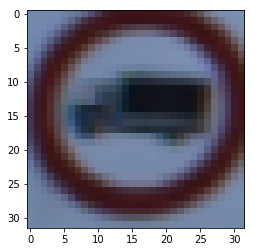

[1.1090537e-13] [5.7751263e-28] [2.6037651e-23] [1.7631248e-10]
[4.4105847e-11]


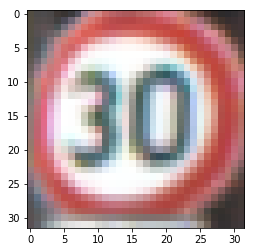

[3.027757e-12] [1.1054923e-18] [6.847927e-12] [2.6211413e-11]
[9.021775e-12]


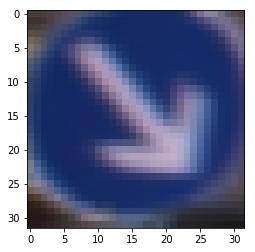

[5.4652663e-17] [2.120777e-28] [5.488904e-22] [3.5198874e-14]
[8.813382e-15]


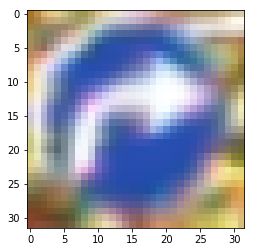

[6.2975385e-05] [4.8658073e-09] [2.5770895e-08] [0.00022278]
[7.144612e-05]


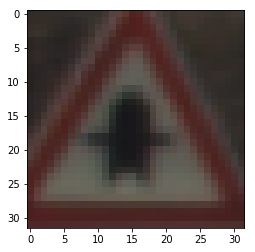

[2.463369e-10] [5.3555174e-15] [7.069696e-09] [5.245561e-09]
[3.1403997e-09]


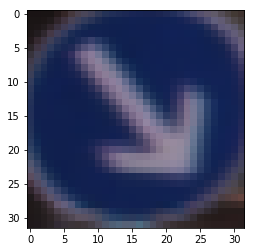

[2.0363341e-11] [2.781902e-25] [5.2628195e-16] [2.3962642e-07]
[5.991169e-08]


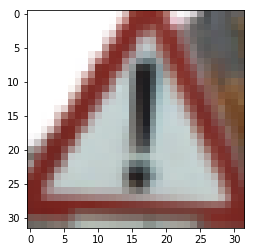

[1.0492296e-10] [8.00921e-17] [5.7422074e-13] [1.8208926e-08]
[4.5786055e-09]


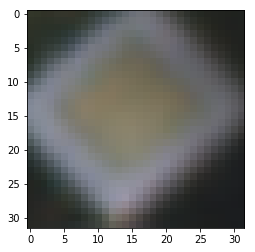

[1.5267301e-11] [3.8571733e-28] [9.742918e-19] [6.8239463e-09]
[1.7098034e-09]


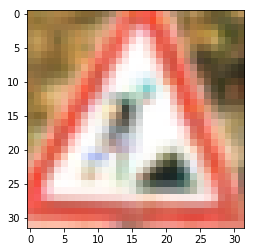

[1.3251154e-12] [1.03564746e-22] [4.5606782e-15] [5.7444876e-09]
[1.4364543e-09]


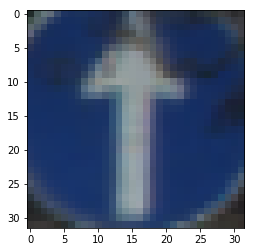

In [16]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.99999416] [0.9999212] [0.99997425] [0.99985945]
[0.9999373]


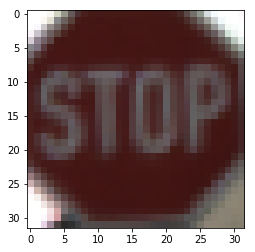

[0.99999976] [0.9999987] [0.99999964] [1.]
[0.9999995]


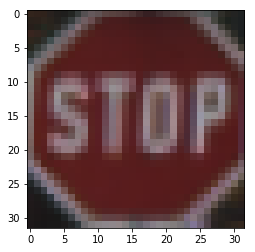

[0.98385644] [0.999998] [0.99999106] [0.9999702]
[0.9959539]


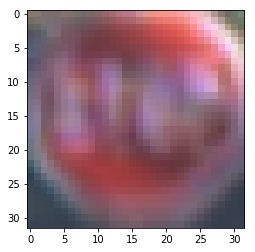

[0.9861432] [0.99999964] [1.] [0.99991596]
[0.9965147]


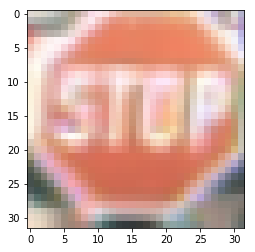

[0.99999964] [0.999997] [0.99999845] [0.9999962]
[0.99999785]


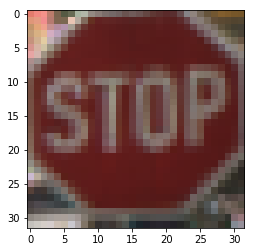

[0.9999993] [0.99999607] [0.9999939] [0.9976361]
[0.99940634]


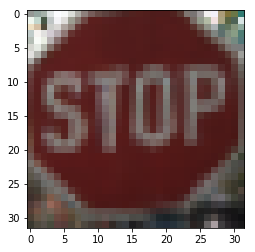

[0.99999964] [0.99999475] [0.99999714] [0.9996649]
[0.9999141]


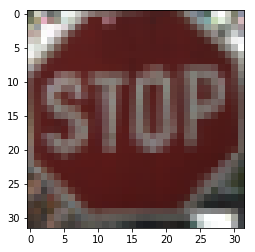

[0.99999964] [0.9999958] [0.9999963] [0.99974054]
[0.99993306]


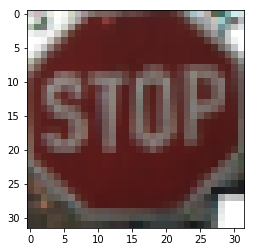

[0.9999993] [0.9999819] [0.9999931] [0.9999999]
[0.99999356]


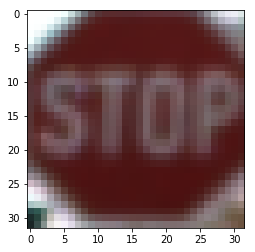

[0.9999987] [0.9999969] [0.9999999] [0.9999999]
[0.9999988]


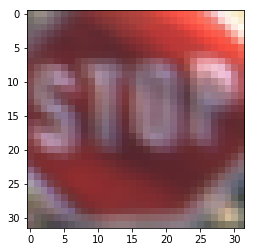

In [17]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.55785596] [0.08812795] [0.17644197] [5.876988e-06]
[0.20560795]


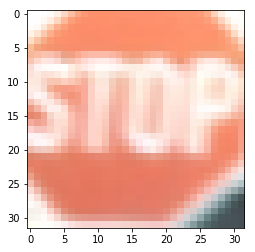

[0.00087485] [0.99971336] [0.0631621] [0.1899125]
[0.3134157]


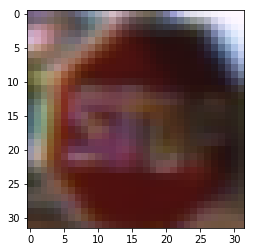

In [24]:
y = featnet.predict_model(sess, X_test_stn[y_test == 14])
ind = np.where(y < 0.5)[0]

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})

for i, x in enumerate(X_test_stn[y_test == 14][ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

- The representations are disentangled so the network presumably learns the features
- However, the feature scores does not indicate the quality of the features
    - We want the final score to be meaningful which can come from the feature scores being meaningful
    - Hinge loss possibly helps... can be used to set threshold of voting
- How to deal with features that appear in multiple classes (like '0')?
    - Manually group in the training set --> break the end-to-end scheme, need to train the feature detectors "separately"
- Philosophical question: how should the features be selected? 
    - Choose by semantic meanings determined by humans? E.g. ask people what do you think X needs to have to be considered a stop sign
        - This is straightforward and robust but not end-to-end
    - Even cooler: let network decides and see if they match with human's choices
        - This is where interpretable ML can come into play
    
# Goals

0. Good clean accuracy
1. Features are robustly detect (interpretability of feature scores is nice to have but doesn't actually matter at this stage)  
    - The main concept is still that "easy task is easy to make robust"
2. No single area/feature of the image that dominates the decision. This is achieved by:
    - Masking and separating streams
    - Use sigmoid to limit contribution of each feature

--- 

# 6

In [10]:
from feat_net import FeatNet

featnet = FeatNet([32, 32, 3], [1], [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=1e-4, save_path="model/featnet.ckpt",
                  stn_weight=stn_weight)

data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: -9.7533
STEP: 50 	Loss: -102.3688
STEP: 100 	Loss: -198.9342
STEP: 150 	Loss: -182.8638
STEP: 200 	Loss: -169.5470
STEP: 250 	Loss: -196.9396
STEP: 300 	Loss: -194.7798
STEP: 350 	Loss: -203.9156
STEP: 400 	Loss: -187.3342
STEP: 450 	Loss: -209.7224
STEP: 500 	Loss: -177.2811
Train Acc|Loss:	0.9914|0.0086
Val Acc|Loss:	0.9843|0.0157
============= EPOCH: 1 =============
STEP: 0 	Loss: -210.7617
STEP: 50 	Loss: -213.2940
STEP: 100 	Loss: -190.7038
STEP: 150 	Loss: -183.8746
STEP: 200 	Loss: -187.3213
STEP: 250 	Loss: -172.5353
STEP: 300 	Loss: -196.4070
STEP: 350 	Loss: -190.2949
STEP: 400 	Loss: -211.6466
STEP: 450 	Loss: -197.9350
STEP: 500 	Loss: -206.0374
Train Acc|Loss:	0.9950|0.0050
Val Acc|Loss:	0.9873|0.0127
============= EPOCH: 2 =============
STEP: 0 	Loss: -185.8571
STEP: 50 	Loss: -194.0864
STEP: 100 	Loss: -176.9302
STEP: 150 	Loss: -181.9420
STEP: 200 	Loss: -187.1022
STEP: 250 	Loss: -155.9460
STEP: 300 	Loss: -211.4507
S

In [21]:
y = featnet.predict_model(sess, X_val_stn)

y_thres = y >= (4*0.75)
print(np.mean(y_thres[y_val_stn == 1]))

0.805324074074074


[1.9698041e-20] [6.190385e-24] [1.7105225e-18] [7.341306e-19]
[2.464364e-18]


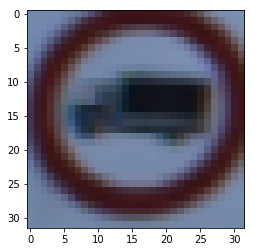

[8.923833e-28] [2.586556e-33] [6.7417885e-30] [6.130052e-20]
[6.130052e-20]


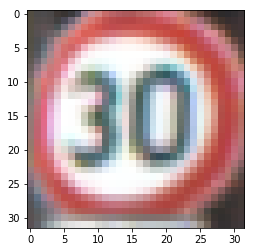

[5.566764e-19] [7.0879137e-19] [1.7000329e-22] [2.0141354e-33]
[1.2656378e-18]


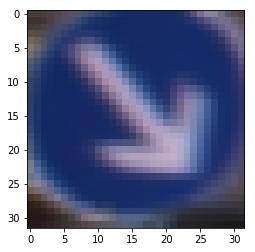

[6.3738493e-37] [2.736322e-30] [1.8917507e-26] [1.08649715e-36]
[1.8920319e-26]


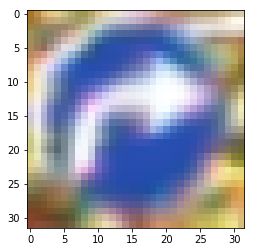

[1.2129823e-09] [1.0787294e-09] [1.2261715e-09] [3.17165e-07]
[3.2068286e-07]


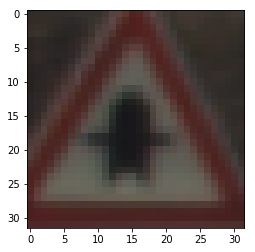

[1.042079e-15] [7.881408e-15] [3.1240094e-17] [8.3755296e-27]
[8.954727e-15]


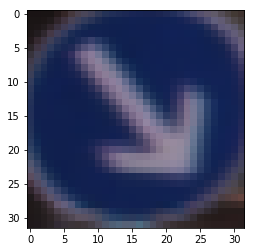

[1.7204869e-28] [6.586814e-32] [3.650658e-21] [2.3512098e-13]
[2.3512098e-13]


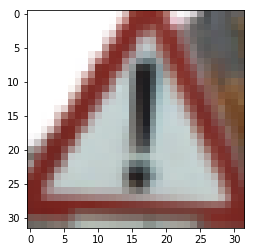

[3.4894918e-22] [2.9348494e-23] [1.4507708e-19] [2.6400377e-18]
[2.785493e-18]


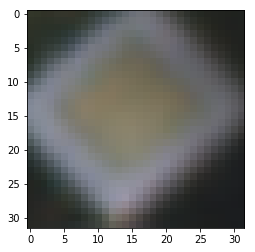

[5.4278515e-23] [3.790376e-32] [4.447501e-33] [3.3087229e-18]
[3.308777e-18]


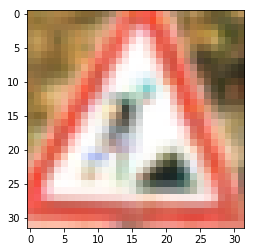

[1.8892028e-21] [1.8673612e-24] [3.0592436e-23] [7.301784e-27]
[1.92167e-21]


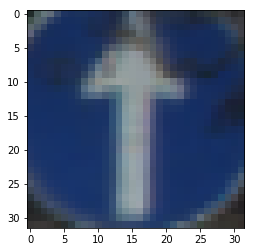

In [13]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[:10]})

for i, x in enumerate(X_test_stn[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.9999881] [0.9996811] [0.9999356] [0.99924767]
[3.9988525]


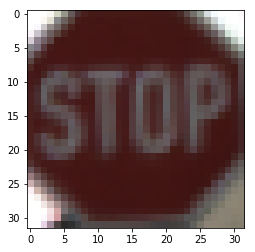

[0.9999999] [0.99999654] [0.99999976] [0.9999856]
[3.9999819]


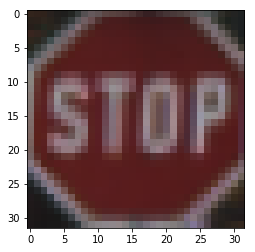

[1.] [0.999998] [0.99999154] [1.8836568e-07]
[2.9999897]


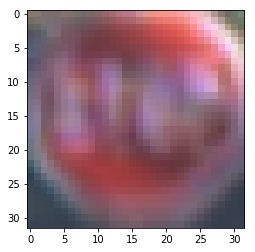

[0.79119277] [1.] [1.] [0.9995621]
[3.7907548]


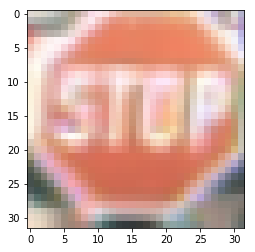

[0.99999917] [0.9999888] [0.99999785] [0.9992398]
[3.9992256]


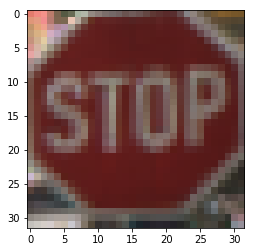

[0.99999857] [0.99998105] [0.99998593] [0.991968]
[3.9919333]


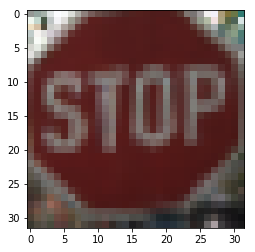

[0.99999964] [0.9999788] [0.9999964] [0.99908173]
[3.9990566]


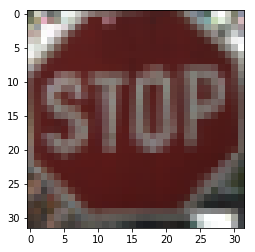

[0.9999993] [0.99998105] [0.99999475] [0.99801093]
[3.9979858]


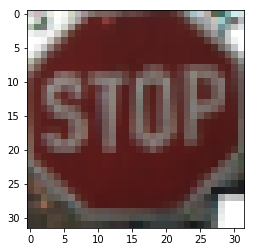

[0.99999774] [0.9999491] [0.99999344] [0.99991786]
[3.9998581]


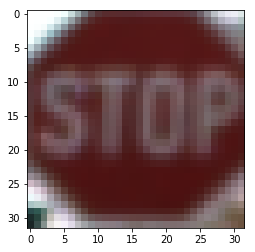

[0.9999969] [0.99999154] [0.9999995] [0.9999944]
[3.9999824]


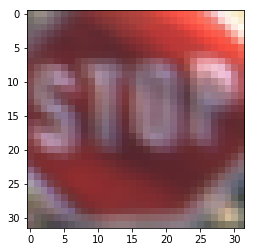

In [14]:
scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][:10]})

for i, x in enumerate(X_test_stn[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[2.7404665e-13] [0.0009693] [1.9934185e-09] [1.0628843e-06]
[0.00097036]


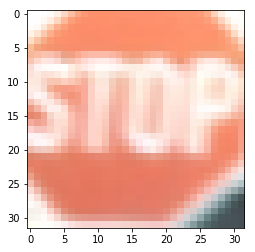

In [15]:
y = featnet.predict_model(sess, X_test_stn[y_test == 14])
ind = np.where(y < 0.5)[0]

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X_test_stn[y_test == 14][ind]})

for i, x in enumerate(X_test_stn[y_test == 14][ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[0.22543047] [7.577896e-07] [1.07983796e-11] [0.20952116]
[0.43495238]


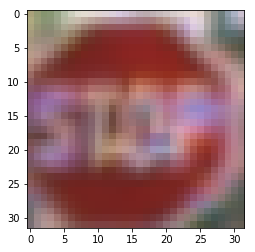

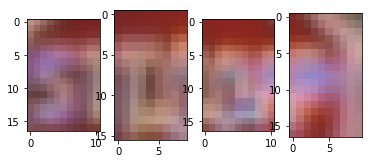

[0.99999464] [0.9990246] [0.9892042] [0.00187154]
[2.9900951]


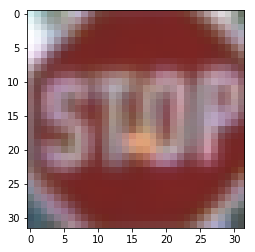

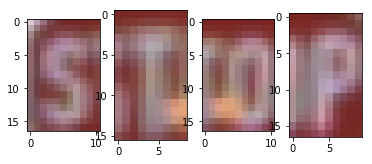

[0.00037602] [0.978456] [0.9983687] [0.99999404]
[2.9771948]


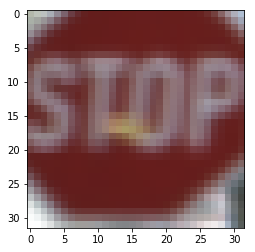

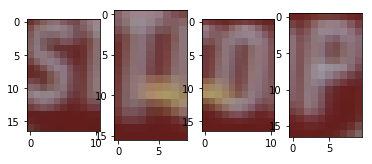

[1.] [0.999998] [1.9601395e-15] [0.0055077]
[2.0055056]


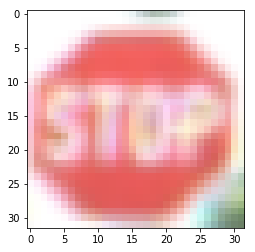

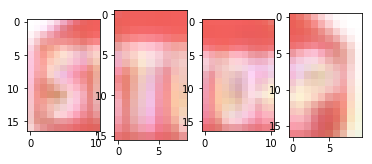

[3.163334e-07] [8.539087e-06] [3.8586145e-06] [0.00272572]
[0.00273844]


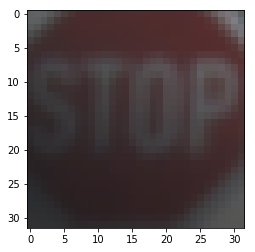

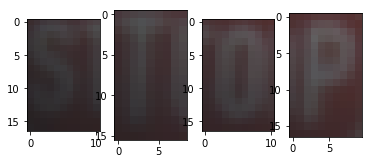

[0.1769141] [0.08789995] [0.00695524] [2.3692248e-10]
[0.2717693]


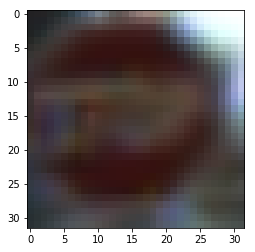

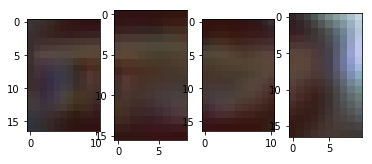

[0.99911433] [0.21505718] [0.15445323] [0.99978215]
[2.3684068]


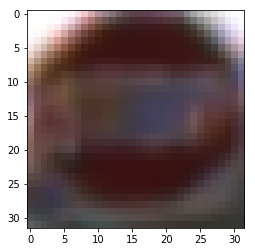

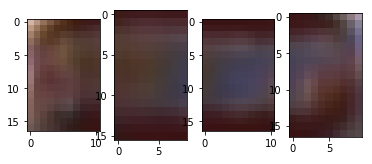

[0.9565052] [0.00926319] [0.0844963] [0.9994966]
[2.0497613]


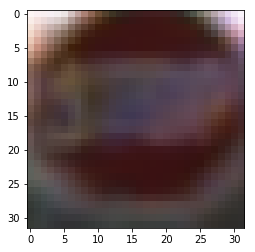

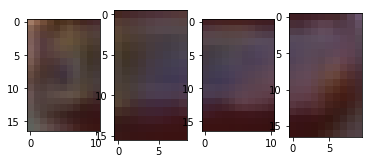

[0.998835] [0.01434289] [0.527647] [0.00631528]
[1.5471401]


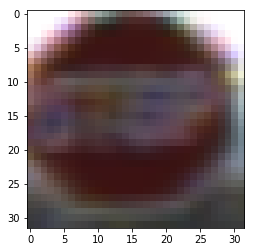

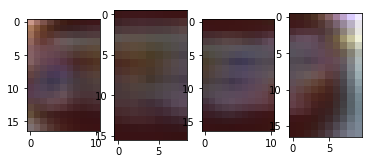

[0.03323227] [0.21347664] [0.01659684] [0.98809975]
[1.2514055]


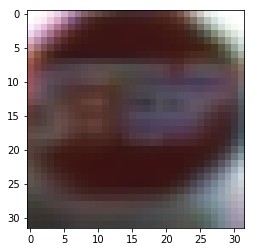

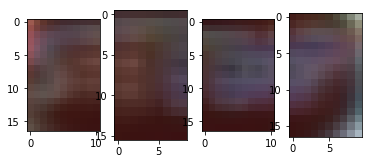

[0.99957174] [0.96220887] [0.70996255] [0.01275059]
[2.6844935]


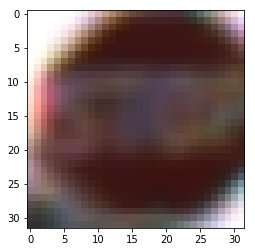

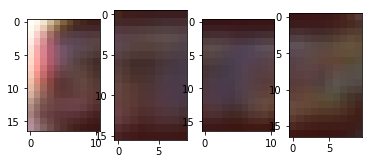

[0.00069927] [0.45796573] [0.07833669] [0.99458647]
[1.5315882]


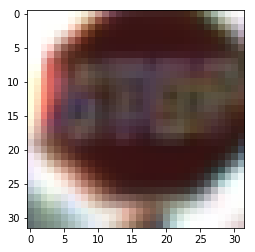

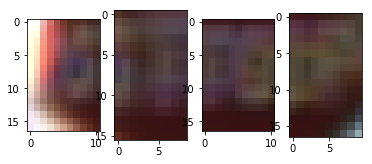

[0.9988887] [0.9997081] [0.9988575] [4.9297725e-08]
[2.9974544]


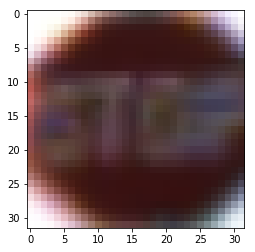

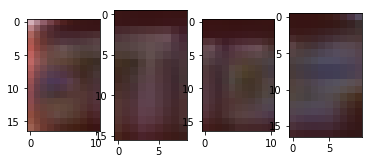

[0.3856039] [0.9540012] [0.03341772] [0.9933123]
[2.3663352]


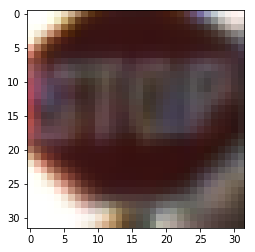

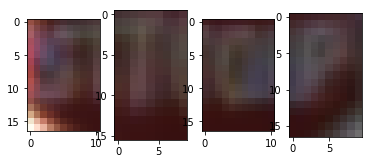

[9.3653514e-05] [0.02637754] [0.00023979] [0.9918305]
[1.0185415]


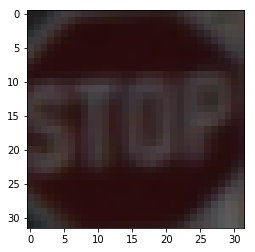

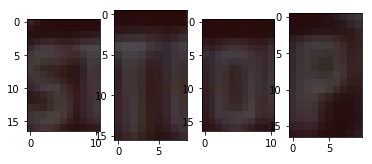

[1.2509937e-05] [0.6636615] [0.9430077] [0.9895605]
[2.5962422]


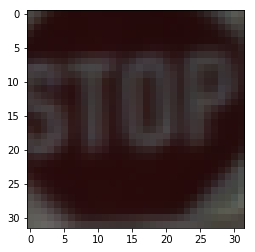

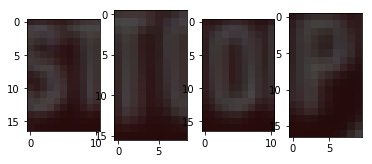

[0.4566545] [0.8888675] [0.20524259] [0.996391]
[2.5471554]


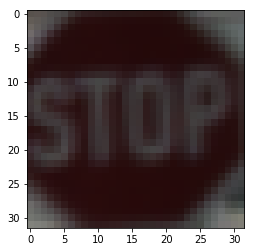

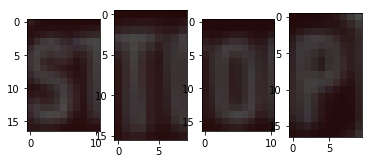

In [32]:
X = X_val[y_val == 14]
X = get_stn_output([X, 0])[0]*0.5 + 0.5
y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

scores = sess.run(featnet.feat_scores, feed_dict={featnet.x: X[ind]})
outputs = sess.run(featnet.output, feed_dict={featnet.x: X[ind]})

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

---

# 7

In [92]:
from feat_net import FeatNet

featnet = FeatNet("featnet_v7", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  learning_rate=5e-4, 
                  save_path="model/featnet_v7.h5",
                  load_model=True,
                  stn_weight=stn_weight)

# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, n_epoch=10, batch_size=128)

In [93]:
featnet.eval_model(sess, (X_val_bal, y_val_bal))

(0.9876157407407408, -1.9468168877893024)

In [94]:
y = featnet.predict_model(sess, X_val_bal)

y_thres = y >= (4*0.75)
print(np.mean(y_thres[y_val_bal == 1]))
y_thres = y < (4*0.75)
print(np.mean(y_thres[y_val_bal == 0]))

0.9756944444444444
0.999537037037037


[0.] [0.] [0.] [3.1175145e-36]
[3.1175145e-36]


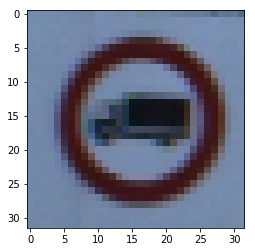

[0.] [0.] [0.] [0.]
[0.]


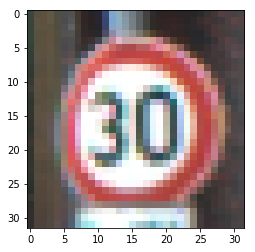

[0.] [1.5622496e-34] [0.] [2.0694188e-31]
[2.070981e-31]


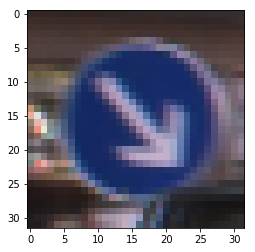

[0.] [0.] [0.] [0.]
[0.]


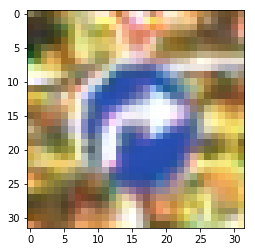

[4.8547754e-13] [5.1834887e-09] [7.515721e-25] [3.548134e-12]
[5.1875224e-09]


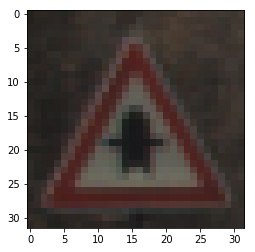

[5.9971274e-34] [6.9312684e-30] [0.] [9.386591e-27]
[9.393523e-27]


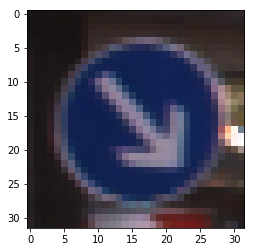

[0.] [0.] [0.] [2.2536827e-36]
[2.2536827e-36]


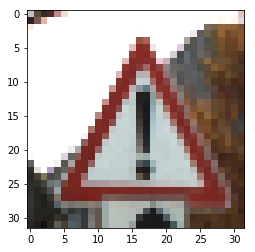

[0.] [1.01860005e-29] [0.] [1.737548e-30]
[1.1923548e-29]


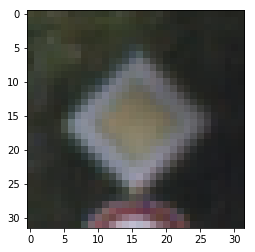

[0.] [0.] [0.] [0.]
[0.]


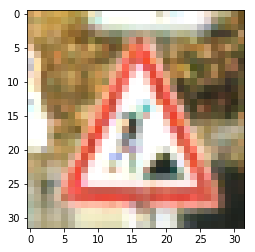

[0.] [0.] [0.] [0.]
[0.]


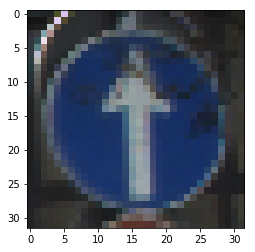

In [95]:
feed_dict = {featnet.model.get_input_at(0): X_test[:10]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X_test[:10]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X_test[:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[1.] [0.99999905] [1.] [1.]
[3.999999]


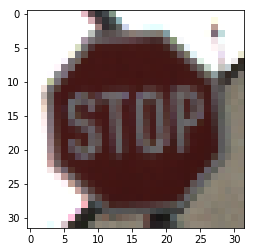

[1.] [1.] [1.] [1.]
[4.]


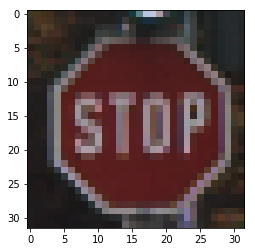

[1.] [1.] [1.] [1.]
[4.]


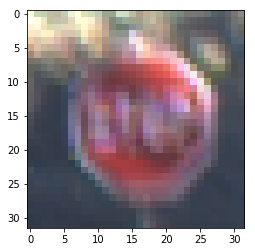

[1.] [1.] [1.] [1.]
[4.]


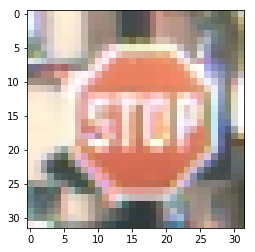

[1.] [1.] [1.] [1.]
[4.]


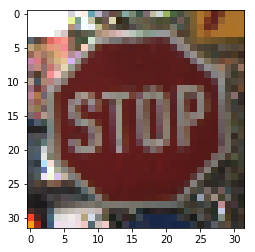

[1.] [0.9999999] [1.] [1.]
[4.]


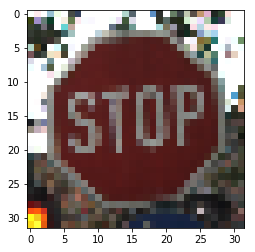

[1.] [0.99999964] [1.] [1.]
[3.9999995]


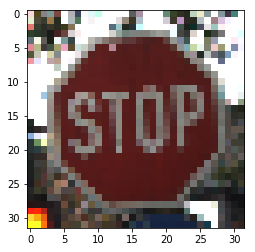

[1.] [0.9999999] [1.] [1.]
[4.]


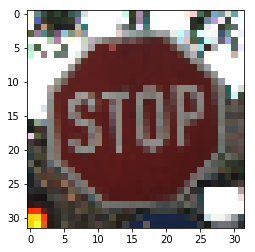

[1.] [1.] [1.] [1.]
[4.]


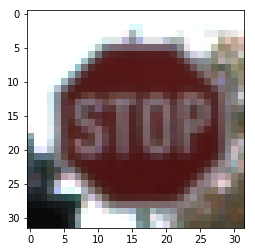

[1.] [1.] [1.] [1.]
[4.]


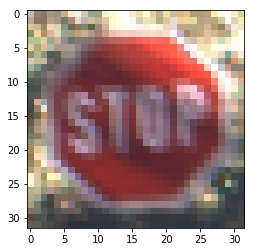

In [44]:
feed_dict = {featnet.model.get_input_at(0): X_test[y_test == 14][:10]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X_test[y_test == 14][:10]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X_test[y_test == 14][:10]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[6.685308e-33] [1.0212516e-33] [5.789125e-23] [1.]
[1.]


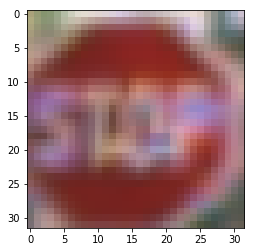

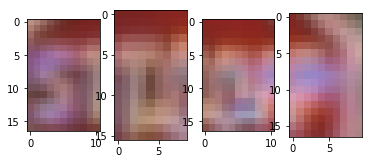

[0.99886] [1.6013563e-13] [0.99997675] [1.]
[2.9988368]


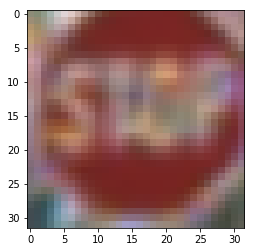

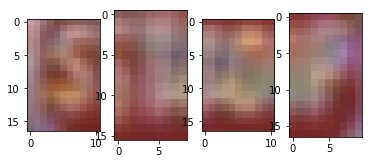

[0.01505172] [2.3041265e-07] [0.9944108] [1.]
[2.0094628]


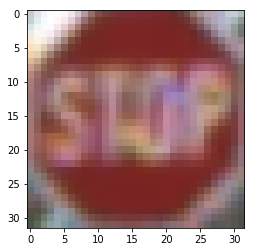

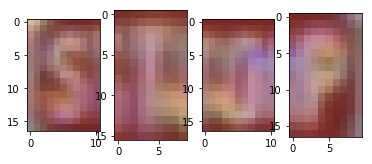

[0.00268441] [2.3234331e-12] [0.9999851] [1.]
[2.0026693]


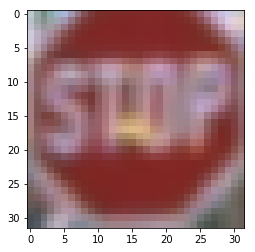

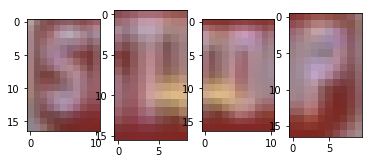

[3.7025114e-07] [8.313058e-13] [0.9891796] [1.]
[1.98918]


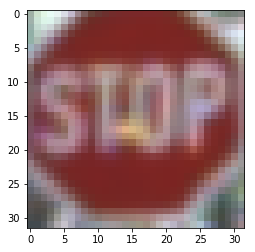

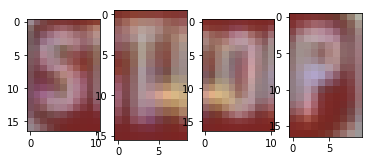

[0.572655] [9.6514104e-17] [0.9985575] [1.]
[2.5712125]


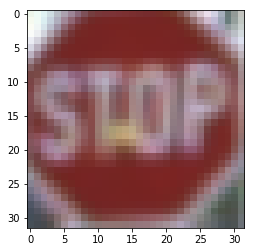

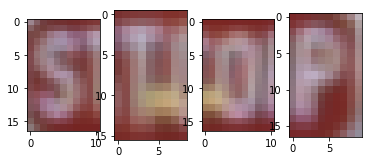

[2.300837e-07] [1.08167e-12] [0.9987708] [1.]
[1.998771]


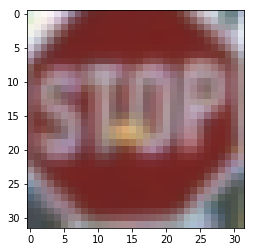

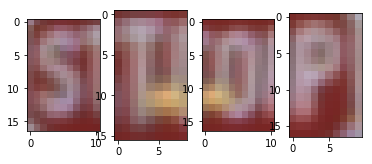

[0.00043884] [2.1507063e-12] [0.98480713] [1.]
[1.985246]


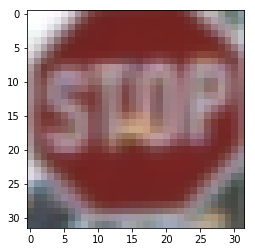

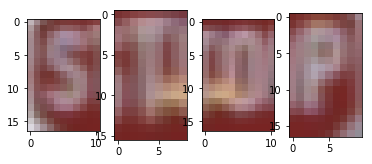

[0.5919139] [1.2738047e-15] [0.08730239] [1.]
[1.6792163]


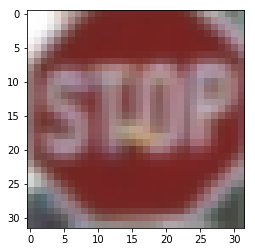

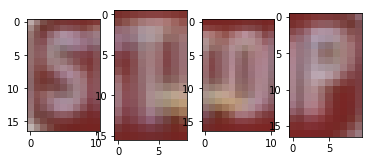

[0.9999466] [7.8678194e-14] [0.9999999] [1.]
[2.9999466]


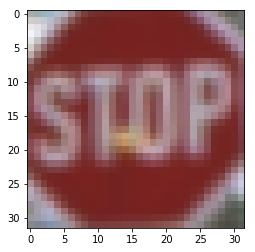

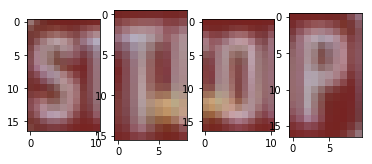

[1.7389226e-05] [2.945313e-12] [0.9993235] [1.]
[1.9993409]


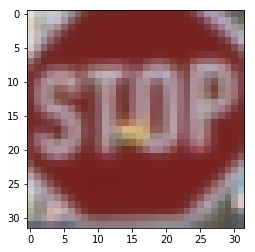

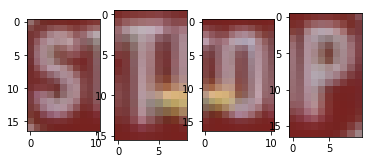

[0.84176624] [0.01363362] [0.99992216] [1.]
[2.855322]


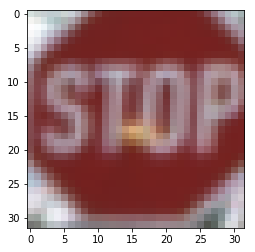

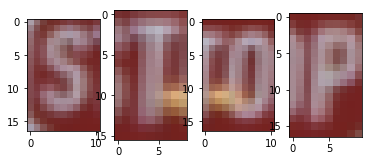

[0.9996824] [6.1325267e-10] [0.99999833] [1.]
[2.9996808]


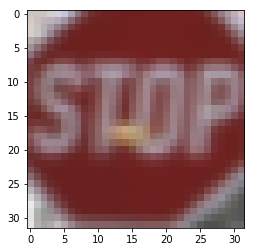

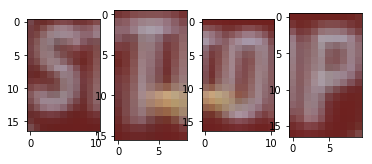

[7.4654455e-10] [5.6062376e-13] [0.37786672] [0.988957]
[1.3668237]


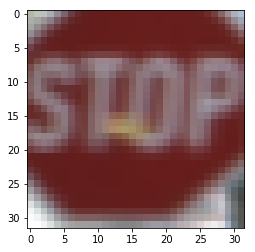

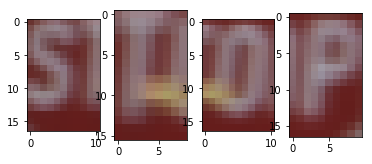

[0.998539] [6.260139e-05] [1.] [1.]
[2.9986014]


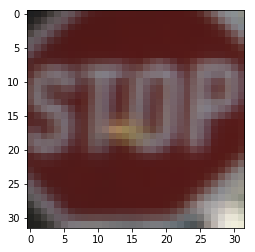

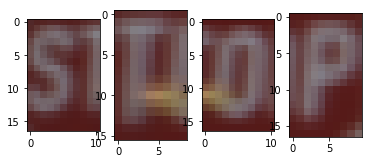

[0.96317875] [5.73419e-06] [0.9999999] [1.]
[2.9631844]


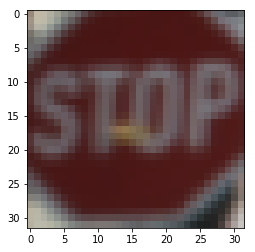

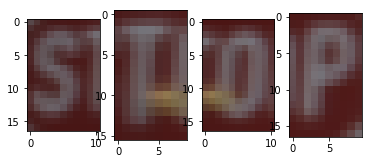

[3.592223e-21] [1.0714656e-14] [1.0358751e-10] [0.99999976]
[0.99999976]


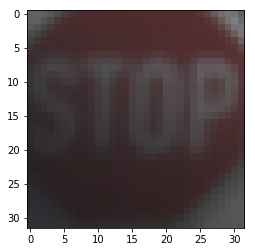

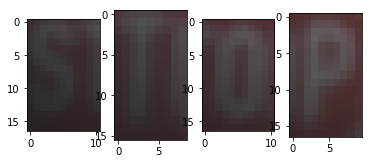

[2.019196e-08] [4.0052686e-09] [0.00193074] [1.]
[1.0019307]


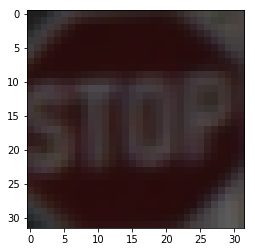

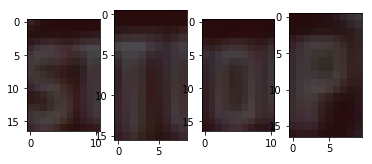

[0.5289125] [6.622825e-05] [0.9999926] [1.]
[2.5289712]


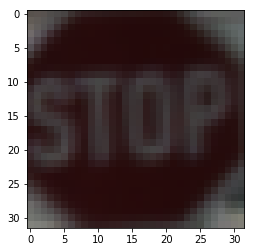

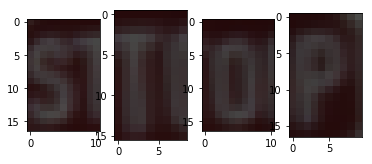

In [45]:
X = X_val[y_val == 14]
X = get_stn_output_v2([X])[0]*0.5 + 0.5
y = featnet.predict_model(sess, X)
ind = np.where(y < 4*0.75)[0]

S = get_patch(X, pos_S)
T = get_patch(X, pos_T)
O = get_patch(X, pos_O)
P = get_patch(X, pos_P)

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

---

# Test Attack

In [46]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Choosing samples to attack
# n_attack = 500
# ind_1 = np.where(np.argmax(y_test, axis=1) == 1)[0]
# ind_14 = np.where(np.argmax(y_test, axis=1) == 14)[0]
# X_atk = np.zeros((n_attack, ) + X_test.shape[1:4])
# X_atk[:n_attack//2] = X_test[ind_1][:n_attack//2]
# X_atk[n_attack//2:] = X_test[ind_14][:n_attack//2]

# y_target = np.zeros((n_attack, ))
# y_target[:n_attack//2] = 14
# y_target[n_attack//2:] = 1
# y_target = to_categorical(y_target, 43)

In [47]:
n_attack = 250
ind_1 = np.where(np.argmax(y_test, axis=1) == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

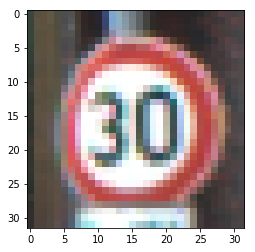

In [48]:
plt.imshow(X_atk[0])

In [123]:
y_pred = model.predict(X_atk)
print("Clean accuracy: ", np.mean(np.argmax(y_pred, axis=1) == 1))
print("Clean acc by featnet: ", np.mean(featnet.predict_model(sess, X_atk) < 3))

FailedPreconditionError: Attempting to use uninitialized value conv2d_126/kernel
	 [[Node: conv2d_126/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_126/kernel)]]
	 [[Node: spatial_transformer_9/Reshape_8/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_132_spatial_transformer_9/Reshape_8", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [113]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:23:03,702 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-10-16 05:23:08,903 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-16 05:23:09,603 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:23:12,619 cleverhans]     Iteration 0 of 200: loss=178 l2=0 l1=3.01
[DEBUG 2018-10-16 05:23:15,375 cleverhans]     Iteration 20 of 200: loss=47.3 l2=20.8 l1=2.6
[DEBUG 2018-10-16 05:23:18,147 cleverhans]     Iteration 40 of 200: loss=36.8 l2=10.7 l1=2.57
[DEBUG 2018-10-16 05:23:20,935 cleverhans]     Iteration 60 of 200: loss=34.8 l2=9.5 l1=2.48
[DEBUG 2018-10-16 05:23:23,720 cleverhans]     Iteration 80 of 200: loss=33.8 l2=8.91 l1=2.45
[DEBUG 2018-10-16 05:23:26,492 cleverhans]     Iteration 100 of 200: loss=33.6 l2=9.72 l1=2.36
[DEBUG 2018-10-16 05:23:29,272 cleverhans]     Iteration 120 of 200: loss=32.5 l2=9.49 l1=2.27
[DEBUG 2018-10-16 05:23:32,042 cleverhans]     Iteration 140 of 200: loss=32.9 l2=10.3 l1=2.24

In [114]:
y_pred = model.predict(adv)
np.mean(np.argmax(y_pred, axis=1) == 14)

0.388

In [115]:
feed_dict = {featnet.x: adv}
out = sess.run(featnet.output, feed_dict=feed_dict)
np.mean(out >= 3)

0.388

In [116]:
featnet.eval_model(sess, (adv, np.ones([n_attack, 1])))

(0.388, 2.495321081161499)

In [117]:
dist = np.sum((adv - X_atk)**2, (1, 2, 3))
np.mean(dist)

5.5913105

[1.] [1.] [1.] [1.]
[4.]


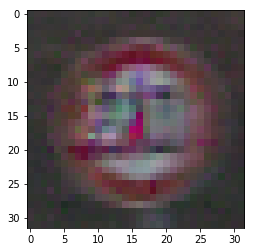

[1.] [1.] [1.] [1.]
[4.]


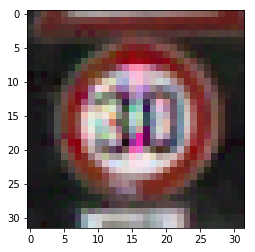

[1.] [1.] [1.] [1.]
[4.]


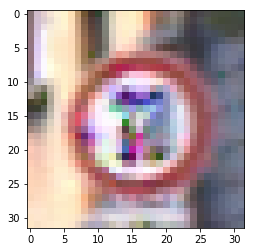

[1.] [1.] [1.] [1.]
[4.]


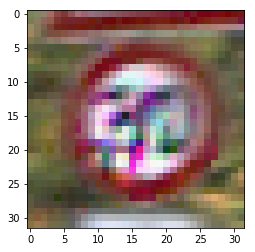

[1.] [1.] [1.] [1.]
[4.]


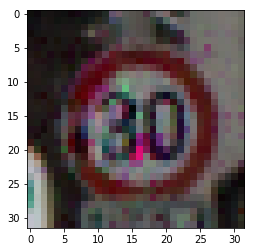

[1.] [1.] [1.] [1.]
[4.]


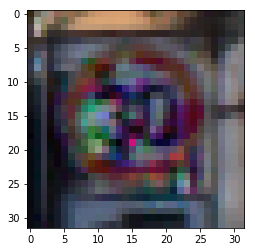

[1.] [1.] [1.] [1.]
[4.]


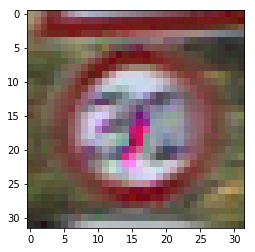

[1.] [1.] [1.] [1.]
[4.]


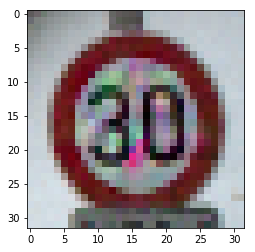

[1.] [1.] [1.] [1.]
[4.]


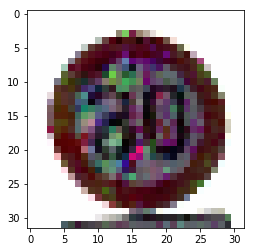

[0.41198385] [1.] [1.] [1.]
[3.411984]


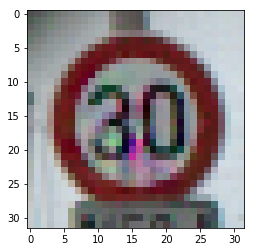

In [118]:
X = adv[np.where(out >= 3)[0]][:10]

feed_dict = {featnet.model.get_input_at(0): X}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

[1.] [1.] [1.] [1.]
[4.]


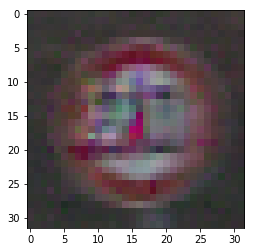

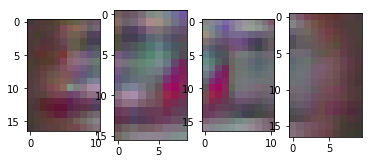

[1.] [1.] [1.] [1.]
[4.]


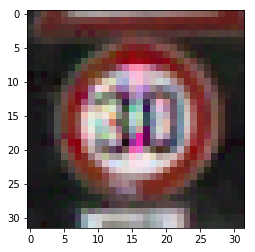

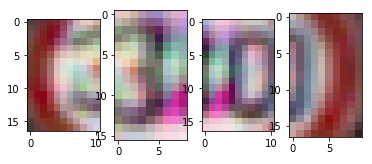

[1.] [1.] [1.] [1.]
[4.]


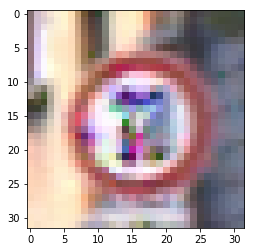

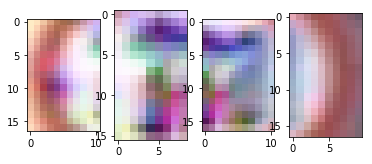

[1.] [1.] [1.] [1.]
[4.]


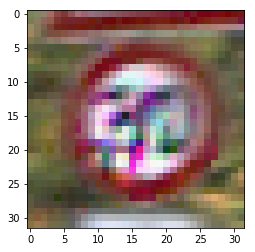

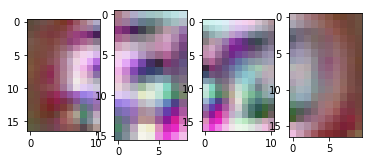

[1.] [1.] [1.] [1.]
[4.]


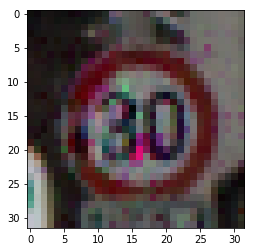

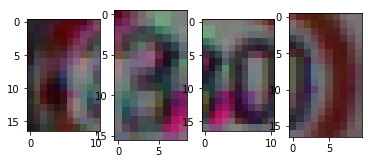

[1.] [1.] [1.] [1.]
[4.]


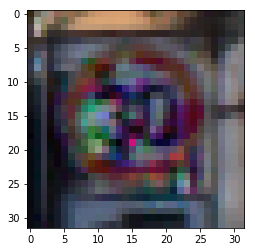

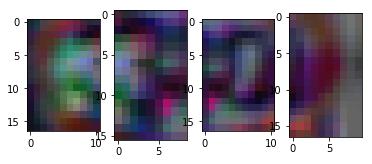

[1.] [1.] [1.] [1.]
[4.]


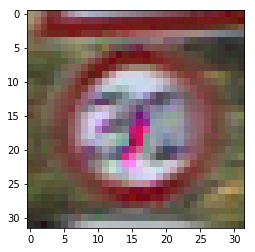

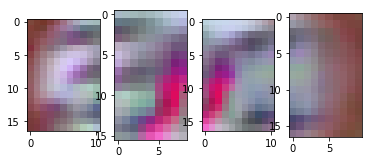

[1.] [1.] [1.] [1.]
[4.]


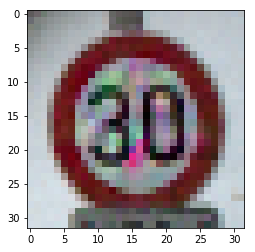

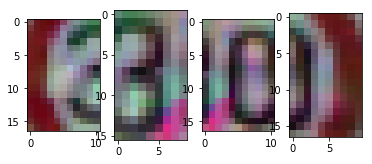

[1.] [1.] [1.] [1.]
[4.]


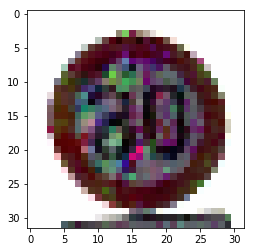

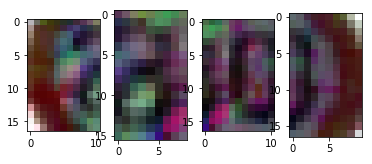

[0.41198385] [1.] [1.] [1.]
[3.411984]


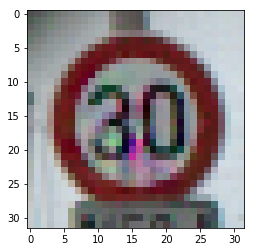

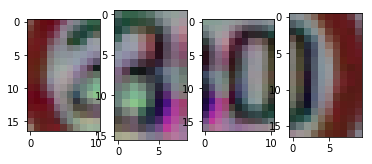

In [121]:
X = adv
y = featnet.predict_model(sess, X)
ind = np.where(y >= 3)[0][:10]

X_stn = get_stn_output_v2([X])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
T = get_patch(X_stn, pos_T)
O = get_patch(X_stn, pos_O)
P = get_patch(X_stn, pos_P)

feed_dict = {featnet.model.get_input_at(0): X[ind]}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X[ind]}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X[ind]):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(S[ind][i])
    axs[1].imshow(T[ind][i])
    axs[2].imshow(O[ind][i])
    axs[3].imshow(P[ind][i])
    plt.show()

In [109]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from cleverhans.attacks import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CarliniWagnerL2(wrap_clf, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:20:42,142 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:20:45,820 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-10-16 05:20:46,425 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:20:48,424 cleverhans]     Iteration 0 of 200: loss=3.69e+04 l2=0 f=-1.81
[DEBUG 2018-10-16 05:20:50,975 cleverhans]     Iteration 20 of 200: loss=5.03e+03 l2=19.7 f=-0.3
[DEBUG 2018-10-16 05:20:53,563 cleverhans]     Iteration 40 of 200: loss=2.39e+03 l2=9.16 f=-0.524
[DEBUG 2018-10-16 05:20:56,097 cleverhans]     Iteration 60 of 200: loss=2e+03 l2=7.63 f=-0.623
[DEBUG 2018-10-16 05:20:58,583 cleverhans]     Iteration 80 of 200: loss=1.99e+03 l2=7.67 f=-0.659
[DEBUG 2018-10-16 05:21:01,077 cleverhans]     Iteration 100 of 200: loss=2.1e+03 l2=8.17 f=-0.703
[DEBUG 2018-10-16 05:21:01,078 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-16 05:21:01,083 cleverhans]   Successfully generated adversarial exampl

In [110]:
y_pred = model.predict(adv)
np.mean(np.argmax(y_pred, axis=1) == 14)

0.984

In [111]:
feed_dict = {featnet.x: adv}
out = sess.run(featnet.output, feed_dict=feed_dict)
np.mean(out >= 3)

0.0

[0.] [0.] [0.] [0.]
[0.]


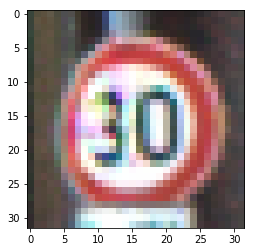

[0.] [0.] [0.] [0.]
[0.]


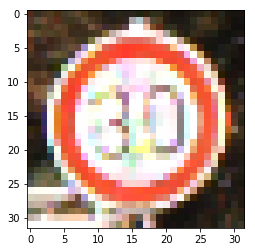

[7.806256e-27] [1.0924627e-18] [0.] [2.3121208e-15]
[2.3132133e-15]


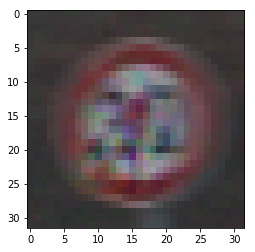

[0.] [0.] [0.] [0.]
[0.]


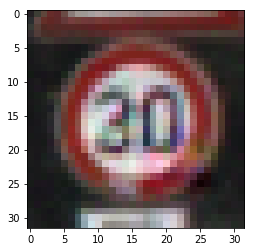

[0.] [0.] [0.] [0.]
[0.]


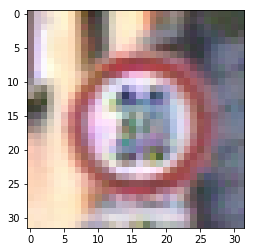

[0.] [0.] [0.] [1.2801619e-37]
[1.2801619e-37]


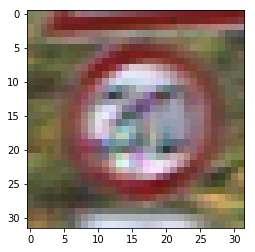

[4.713016e-36] [8.3346595e-22] [0.] [7.1654096e-22]
[1.5500069e-21]


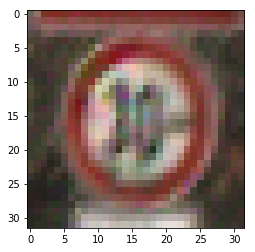

[0.] [0.] [0.] [0.]
[0.]


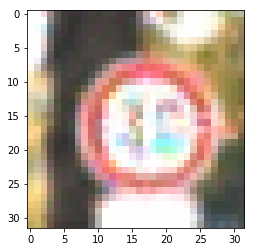

[1.985574e-25] [1.6495492e-18] [0.] [3.1207528e-20]
[1.680757e-18]


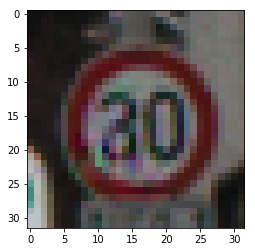

[0.] [2.6027576e-34] [0.] [1.2462754e-34]
[3.849033e-34]


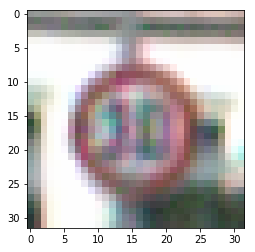

In [112]:
X = adv[np.argmax(y_pred, axis=1) == 14][:10]

feed_dict = {featnet.model.get_input_at(0): X}
scores = sess.run(featnet.feat_scores, feed_dict=feed_dict)
feed_dict = {featnet.x: X}
outputs = sess.run(featnet.output, feed_dict=feed_dict)

for i, x in enumerate(X):
    print(scores[0][i], scores[1][i], scores[2][i], scores[3][i])
    print(outputs[i])
    plt.imshow(x)
    plt.show()

In [ ]:
# Overlap problem